In [1]:
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torchnet as tnt
from torchnet.engine import Engine
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import models


from torch.utils.data import Dataset, DataLoader
import h5py
from torchvision import transforms

import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm_notebook as tqdm
from torchsummary import summary

print(torch.__version__)
device = torch.device('cuda:0')

In [2]:
class Snoringread(Dataset):
    def __init__(self, name, transform=None):
        hf = h5py.File(name, 'r')
        self.specs = np.array(hf.get('spectrograms'), np.uint8)
        self.labels = np.array(hf.get('targets')).astype(np.long)
        self.cls = np.array(hf.get('class')).astype(np.long)
        self.transform = transform
        hf.close()

    def __len__(self):
        return self.specs.shape[0]

    def __getitem__(self, idx):
        image = self.specs[idx]
        label = self.labels[idx]
        cls =  self.cls[idx]
        image = image[None, :]
        #image = np.transpose(image, (2, 0, 1))
        
        return image, label, cls
    
    
class Snoringread_with_class_id(Dataset):
    def __init__(self, name, class_id=[1, 4, 5, 7, 8, 9]):
        hf = h5py.File(name, 'r')
        specs = np.array(hf.get('spectrograms'), np.uint8)
        labels = np.array(hf.get('targets')).astype(np.long)
        cls = np.array(hf.get('class')).astype(np.long)
        hf.close()
        
        index = cls == -1
        for i in class_id:
            index = np.logical_or(index, cls == i)
        self.specs = specs[index]
        self.labels = labels[index]
        self.cls = cls[index]

    def __len__(self):
        return self.specs.shape[0]

    def __getitem__(self, idx):
        image = self.specs[idx]
        label = self.labels[idx]
        cls =  self.cls[idx]
        
        image = image[None, :]
        
        return image, label, cls

In [3]:
data_path = os.path.dirname(os.getcwd()) + "/data/snoring/"
Train_data = Snoringread_with_class_id(data_path + "snoring1s.h5", class_id=[1, 4, 8, 7, 9])
Test_data = Snoringread_with_class_id(data_path + "snoring1s.h5", class_id=[5])

Train_dataloader = DataLoader(dataset=Train_data, batch_size = 32, shuffle=True)
Test_dataloader = DataLoader(dataset=Test_data, batch_size = 32, shuffle=False)

print(Train_data.__len__())

def get_iterator(mode):
    if mode is True:
        return Train_dataloader
    elif mode is False:
        return Test_dataloader

42522


In [4]:
class Weight_loss(nn.Module):
    def __init__(self, w = [0.5, 0.5]):
        super(Weight_loss, self).__init__()
        weights = torch.tensor(w).to(device)
        self._loss = nn.CrossEntropyLoss(weight = weights)
        
    def forward(self, predicted, true):
        predicted = F.softmax(predicted, dim=1)
        return self._loss(predicted, true)

In [5]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [6]:
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            #nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
        )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class Simpel_Model(nn.Module):
    def __init__(self, num_classes=2):
        super(Simpel_Model, self).__init__()
        self.last_channel = 128
        width_mult = 1
        input_channel = 8
        inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 2, 1],
                [6, 24, 2, 2],
                [6, 32, 2, 2],
                [6, 64, 2, 2],
                [6, 96, 2, 2],
            ]
        
        
        features = [ConvBNReLU(in_planes = 1, out_planes = input_channel, stride=2)]
        
        for t, c, n, s in inverted_residual_setting:
            output_channel = c * width_mult
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel    
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1))
        self.features = nn.Sequential(*features)
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )
        
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        
        return x

In [7]:
from torchsummary import summary
train_images, _, _ = next(iter(Test_dataloader))

_model = Simpel_Model(num_classes = 2)
summary(_model, input_size= train_images[0].size(), device="cpu")
_model = _model.to(device)

_loss = Weight_loss(w = [0.8, 0.2])
#_loss = LabelSmoothingLoss(classes = 2, smoothing = 0.1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 65, 15]              72
             ReLU6-2            [-1, 8, 65, 15]               0
            Conv2d-3            [-1, 8, 65, 15]              72
             ReLU6-4            [-1, 8, 65, 15]               0
            Conv2d-5           [-1, 16, 65, 15]             128
       BatchNorm2d-6           [-1, 16, 65, 15]              32
  InvertedResidual-7           [-1, 16, 65, 15]               0
            Conv2d-8           [-1, 16, 65, 15]             144
             ReLU6-9           [-1, 16, 65, 15]               0
           Conv2d-10           [-1, 16, 65, 15]             256
      BatchNorm2d-11           [-1, 16, 65, 15]              32
 InvertedResidual-12           [-1, 16, 65, 15]               0
           Conv2d-13           [-1, 96, 65, 15]           1,536
            ReLU6-14           [-1, 96,

In [8]:
def main():
    #main processor
    def h(sample):
        data, labels, _, training = sample
        
        if(training):
            _model.train()
        else:
            _model.eval()
        labels = torch.LongTensor(labels).to(device)
       
        data = data.to(device).float()
        
        logits = _model(data)
        loss = _loss(logits, labels)
        
        p = F.softmax(logits, dim=1)
        return loss, p
    
    #---------log--------------
    def plot_log(log):
        log = np.array(log)
        fig = plt.figure(figsize = (12, 6))
        #loss
        plt.plot(log[:,0]); plt.plot(log[:,2])
        plt.title("Loss per epoch"); plt.xlabel("epochs"); plt.ylabel("error")
        plt.legend(["training loss", "validation loss"])
        plt.show()
        fig = plt.figure(figsize = (12, 6))
        #accuracy
        max_value = np.round(np.max(log[:, 3]), decimals=4)
        max_index = np.argmax(log[:, 3])
        plt.plot(log[:,1]); plt.plot(log[:,3])
        plt.text(max_index, max_value, str(max_value), fontsize=10)
        plt.title("Accuracy per epoch"); plt.xlabel("epochs"); plt.ylabel("ACC")
        plt.legend(["training accuracy", "validation accuracy"])
        plt.show()
        
    log = []
    engine = Engine()
    EPOCHS = 100
    optimizer = torch.optim.SGD(_model.parameters(), lr=0.001)
    meter_loss = tnt.meter.AverageValueMeter()
    classerr = tnt.meter.ClassErrorMeter(accuracy=True)
    
    def reset_meters():
        classerr.reset()
        meter_loss.reset()
    def on_sample(state):
        state['sample'].append(state['train'])
    def on_forward(state):
        classerr.add(state['output'].data, torch.LongTensor(state['sample'][1]))
        meter_loss.add(state['loss'].item())
    def on_start_epoch(state):
        reset_meters()
        state['iterator'] = tqdm(state['iterator'], desc="[Epoch %d / %d]"%(state['epoch'] + 1, EPOCHS))
    def on_end_epoch(state):
        log.append([])
        display.clear_output(wait=True)
        print('Training loss: %.4f, accuracy: %.4f%%' % (meter_loss.value()[0], classerr.value()[-1]))
        # do validation at the end of each epoch
        log[-1].append(meter_loss.value()[0])
        log[-1].append(classerr.value()[0])
        
        reset_meters()
        engine.test(h, get_iterator(False))
        print('Testing loss: %.4f, accuracy: %.4f%%' % (meter_loss.value()[0], classerr.value()[-1]))
        log[-1].append(meter_loss.value()[0])
        log[-1].append(classerr.value()[0])
        
        if(classerr.value()[-1] == np.max(np.array(log)[:, 3])):
            torch.save(_model.state_dict(), 'epochs/1s_TEST5.pt')
        
        plot_log(log)
        plt.pause(0.005)
        
    engine.hooks['on_sample'] = on_sample
    engine.hooks['on_forward'] = on_forward
    engine.hooks['on_start_epoch'] = on_start_epoch
    engine.hooks['on_end_epoch'] = on_end_epoch
    engine.train(h, get_iterator(True), maxepoch=EPOCHS, optimizer=optimizer)

Training loss: 0.3248, accuracy: 97.9681%
Testing loss: 0.3264, accuracy: 98.6139%


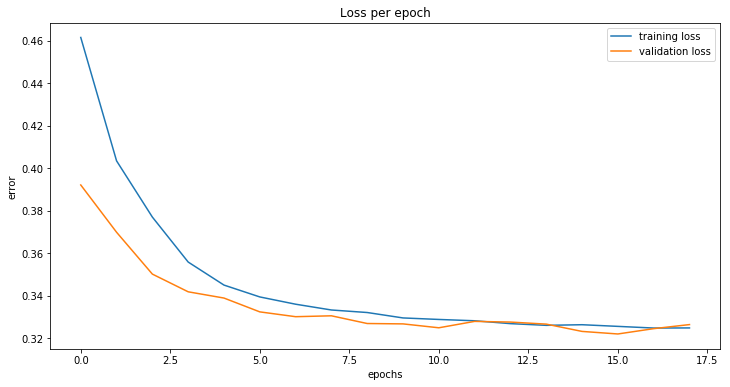

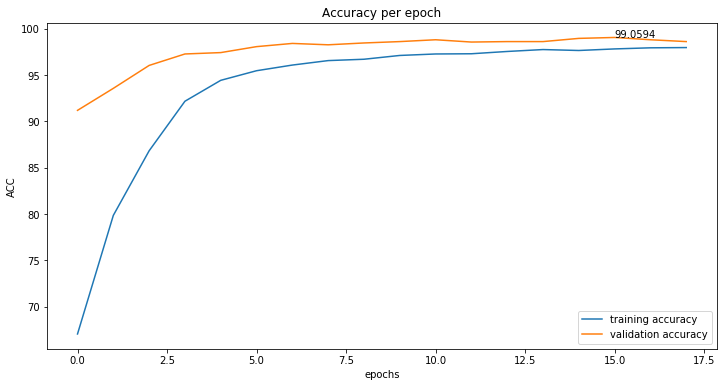

In [ ]:
main()